In [49]:
import pandas as pd
import geopandas as gpd
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import r2_score
from pandas.errors import ParserError

In [19]:
for dir in glob.glob("D:/purpleair/test*"):
    print(dir)
    sensor_list = pd.read_csv(f"{dir}/sensors_list.csv",quotechar='"')
    sensor_list = sensor_list.set_axis(['sensor_index','name','location_type','latitude','longitude'], axis=1)
    df = None
    for fn in glob.glob(f"{dir}/sensorsID*.csv"):
        curr = pd.read_csv(fn)
        if df is None:
            df = curr
        else:
            df = pd.concat([df,curr])
    df = pd.merge(df,sensor_list,on='sensor_index',how='inner')
    df['date_time_utc'] = pd.to_datetime(df['date_time_utc'], format="%Y-%m-%d %H:%M:%S")
    df.to_pickle(f"{dir}/all.pkl")

D:/purpleair\test2
D:/purpleair\test3
D:/purpleair\test4


In [2]:
pd.read_pickle("D:/purpleair/test4/all.pkl").columns

Index(['time_stamp', 'sensor_index', 'humidity_a', 'temperature_a',
       'pressure_a', 'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a',
       'pm2.5_cf_1_b', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1_a',
       'pm10.0_cf_1_b', 'id', 'date_time_utc', 'name', 'location_type',
       'latitude', 'longitude'],
      dtype='object')

In [3]:
pd.read_pickle("D:/purpleair/hourly/20200901_00.pkl").columns

Index(['time_stamp', 'sensor_index', 'humidity_a', 'temperature_a',
       'pressure_a', 'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a',
       'pm2.5_cf_1_b', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1_a',
       'pm10.0_cf_1_b', 'id', 'date_time_utc', 'name', 'location_type',
       'latitude', 'longitude', 'geometry', 'index_right', 'AQSID', 'SiteName',
       'Status', 'EPARegion', 'Latitude', 'Longitude', 'Elevation',
       'GMTOffset', 'CountryCode', 'StateName', 'ValidDate', 'ValidTime',
       'DataSource', 'ReportingArea_PipeDelimited', 'OZONE_AQI', 'PM10_AQI',
       'PM25_AQI', 'NO2_AQI', 'OZONE_Measured', 'PM10_Measured',
       'PM25_Measured', 'NO2_Measured', 'PM25', 'PM25_Unit', 'OZONE',
       'OZONE_Unit', 'NO2', 'NO2_Unit', 'CO', 'CO_Unit', 'SO2', 'SO2_Unit',
       'PM10', 'PM10_Unit', 'pm25_pa'],
      dtype='object')

In [44]:
print(pa_all.columns)

Index(['time_stamp', 'sensor_index', 'humidity_a', 'temperature_a',
       'pressure_a', 'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a',
       'pm2.5_cf_1_b', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1_a',
       'pm10.0_cf_1_b', 'id', 'date_time_utc', 'name', 'location_type',
       'latitude', 'longitude', 'geometry', 'index_right', 'AQSID', 'SiteName',
       'Status', 'EPARegion', 'Latitude', 'Longitude', 'Elevation',
       'GMTOffset', 'CountryCode', 'StateName', 'ValidDate', 'ValidTime',
       'DataSource', 'ReportingArea_PipeDelimited', 'OZONE_AQI', 'PM10_AQI',
       'PM25_AQI', 'NO2_AQI', 'OZONE_Measured', 'PM10_Measured',
       'PM25_Measured', 'NO2_Measured', 'PM25', 'PM25_Unit', 'OZONE',
       'OZONE_Unit', 'NO2', 'NO2_Unit', 'CO', 'CO_Unit', 'SO2', 'SO2_Unit',
       'PM10', 'PM10_Unit', 'pm25_pa'],
      dtype='object')


In [57]:
pa_all = None
for dir in glob.glob("D:/purpleair/test*"):
    curr = pd.read_pickle(f"{dir}/all.pkl")
    if pa_all is None:
        pa_all = curr
    else:
        pa_all = pd.concat([pa_all,curr]).reset_index(drop=True)

pa_all['pm25_pa'] = (pa_all['pm2.5_cf_1_a']+pa_all['pm2.5_cf_1_b'])/2

pa_all_qa = pa_all.copy()
pa_all_qa = pa_all_qa[(pa_all_qa['pm2.5_cf_1_a'] <= 2629.9) & (pa_all_qa['pm2.5_cf_1_b'] <= 2629.9)]
pa_all_qa = pa_all_qa[(pa_all_qa['pm2.5_cf_1_a'] >= 0) & (pa_all_qa['pm2.5_cf_1_b'] >= 0)]
pa_all_qa = pa_all_qa[pa_all_qa["pm2.5_cf_1_a"] != pa_all_qa["pm2.5_cf_1_b"]]
pa_all_qa = pa_all_qa[pa_all_qa["temperature_a"] < 1000]
pa_all_qa = pa_all_qa[(pa_all_qa["humidity_a"] >= 0) & (pa_all_qa["humidity_a"] <= 100)]
abs_diff = (pa_all_qa["pm2.5_cf_1_a"] - pa_all_qa["pm2.5_cf_1_b"]).abs()
per_diff = abs_diff * 2 / (pa_all_qa["pm2.5_cf_1_a"] + pa_all_qa["pm2.5_cf_1_b"])
pa_all_qa = pa_all_qa[(abs_diff < 5) | (per_diff < 0.61)]

for time, group in pa_all.groupby("date_time_utc"):
    hourly = group.sort_values("sensor_index").reset_index(drop=True)
    hourly.to_pickle(f"D:/purpleair/hourly/{time.strftime('%Y%m%d_%H')}.pkl")

for time, group in pa_all_qa.groupby("date_time_utc"):
    hourly = group.sort_values("sensor_index").reset_index(drop=True)
    hourly.to_pickle(f"D:/purpleair/hourlyqa/{time.strftime('%Y%m%d_%H')}.pkl")

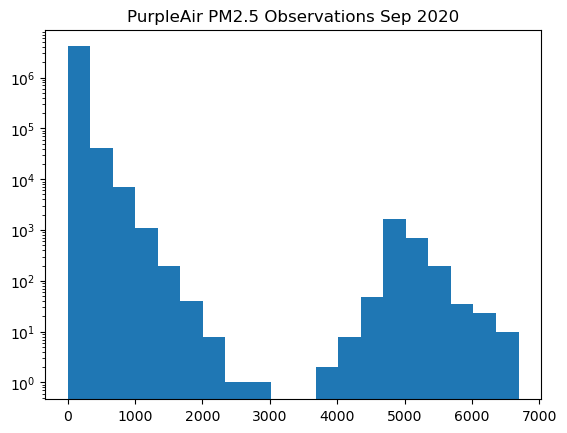

In [4]:
plt.hist((all['pm2.5_cf_1_a']+all['pm2.5_cf_1_b'])/2,bins=20,log=True)
plt.title("PurpleAir PM2.5 Observations Sep 2020")
plt.show()

In [56]:
mx=0
for f in glob.glob("D:/airnow/*.dat"):
    try:
        df = pd.read_csv(f)
        mx = max(mx, df.PM25.max())
    except:
        pass
mx

2629.9

In [58]:
crs = "+proj=aea +lat_1=29.5 +lat_2=42.5"
date_range = pd.date_range(start="20200830", end="20201011", freq="H")

all = None
all_qa = None
for date in date_range:
    try:
        print(date)
        pa = pd.read_pickle(f"D:/purpleair/hourly/{date.strftime('%Y%m%d_%H')}.pkl")
        pa_qa = pd.read_pickle(f"D:/purpleair/hourlyqa/{date.strftime('%Y%m%d_%H')}.pkl")
        an = pd.read_csv(f"D:/airnow/HourlyAQObs_{date.strftime('%Y%m%d%H')}.dat")
        an = an.loc[(an.Latitude < 52) & (an.Latitude > 24) & (an.Longitude < -64) & (an.Longitude > -137) & (~np.isnan(an.PM25))]
        pa = gpd.GeoDataFrame(data=pa,geometry=gpd.points_from_xy(pa.longitude,pa.latitude),crs="EPSG:4326").to_crs(crs)
        pa_qa = gpd.GeoDataFrame(data=pa_qa,geometry=gpd.points_from_xy(pa_qa.longitude,pa_qa.latitude),crs="EPSG:4326").to_crs(crs)
        an = gpd.GeoDataFrame(data=an,geometry=gpd.points_from_xy(an.Longitude,an.Latitude),crs="EPSG:4326").to_crs(crs)
        joined = gpd.sjoin_nearest(pa, an, how="inner", max_distance=100)
        joined_qa = gpd.sjoin_nearest(pa_qa, an, how="inner", max_distance=100)
        if all is None:
            all = joined
        else:
            all = pd.concat([all,joined])
        if all_qa is None:
            all_qa = joined_qa
        else:
            all_qa = pd.concat([all_qa,joined_qa])
    except (FileNotFoundError, ParserError) as e:
        print(f"failed to process {date} {e}")
all = all.reset_index(drop=True)
all.to_pickle("D:/rrfs/all.pkl")
all_qa = all_qa.reset_index(drop=True)
all_qa.to_pickle("D:/rrfs/all_qa.pkl")

2020-08-30 00:00:00
failed to process 2020-08-30 00:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083000.dat'
2020-08-30 01:00:00
failed to process 2020-08-30 01:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083001.dat'
2020-08-30 02:00:00
failed to process 2020-08-30 02:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083002.dat'
2020-08-30 03:00:00
failed to process 2020-08-30 03:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083003.dat'
2020-08-30 04:00:00
failed to process 2020-08-30 04:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083004.dat'
2020-08-30 05:00:00
failed to process 2020-08-30 05:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083005.dat'
2020-08-30 06:00:00
failed to process 2020-08-30 06:00:00 [Errno 2] No such file or directory: 'D:/airnow/HourlyAQObs_2020083006.dat'
2020-08-30 07:00:00
failed to process 2020-08-30 07:00:00 [Err

In [27]:
print(all.columns)

Index(['time_stamp', 'sensor_index', 'humidity_a', 'temperature_a',
       'pressure_a', 'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a',
       'pm2.5_cf_1_b', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1_a',
       'pm10.0_cf_1_b', 'id', 'date_time_utc', 'name', 'location_type',
       'latitude', 'longitude', 'geometry', 'index_right', 'AQSID', 'SiteName',
       'Status', 'EPARegion', 'Latitude', 'Longitude', 'Elevation',
       'GMTOffset', 'CountryCode', 'StateName', 'ValidDate', 'ValidTime',
       'DataSource', 'ReportingArea_PipeDelimited', 'OZONE_AQI', 'PM10_AQI',
       'PM25_AQI', 'NO2_AQI', 'OZONE_Measured', 'PM10_Measured',
       'PM25_Measured', 'NO2_Measured', 'PM25', 'PM25_Unit', 'OZONE',
       'OZONE_Unit', 'NO2', 'NO2_Unit', 'CO', 'CO_Unit', 'SO2', 'SO2_Unit',
       'PM10', 'PM10_Unit', 'pm25_pa'],
      dtype='object')


<Axes: xlabel='pm25_pa', ylabel='PM25'>

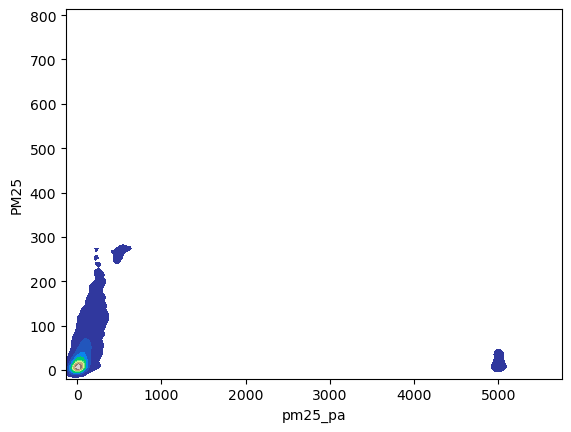

In [17]:
sns.kdeplot(x=all.pm25_pa, y=all.PM25, cmap="terrain", fill=True, bw_adjust=.5)

In [54]:
d = all.groupby(['AQSID','date_time_utc'])[['pm25_pa','humidity_a','PM25']].agg(np.nanmean)
d = d.dropna()
x = d[['pm25_pa','humidity_a']]
y = d[['PM25']]

reg = linear_model.LinearRegression()
reg.fit(x,y)
print(reg.coef_,reg.intercept_)
print(reg.score(x,y))
print(np.mean((y-reg.predict(x))**2)**0.5)

[[0.38363538 0.10788605]] [2.85771278]
0.5699555188468478
48.02639684141102


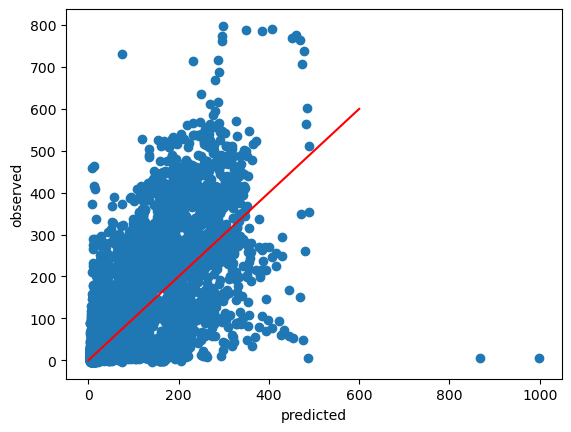

In [55]:
plt.scatter(reg.predict(x),y)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot([0,600],[0,600],color='r')
plt.show()

<Axes: xlabel='pm25_pa', ylabel='PM25'>

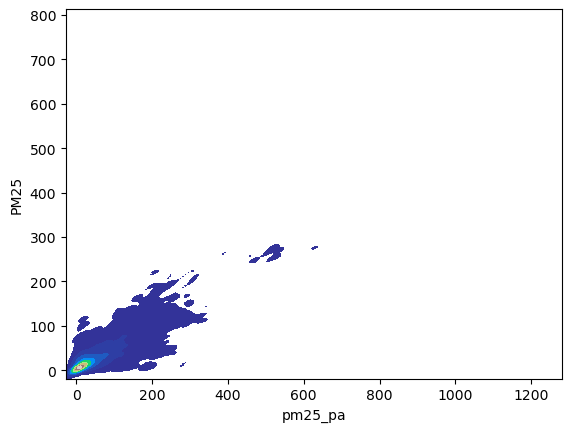

In [32]:
sns.kdeplot(x=all_qa.pm25_pa, y=all_qa.PM25, cmap="terrain", fill=True, bw_adjust=.5)

In [61]:
d = all_qa.groupby(['AQSID','date_time_utc'])[['pm25_pa','humidity_a','PM25']].agg(np.nanmean)
d = d.dropna()
x = d[['pm25_pa','humidity_a']].to_numpy()
y = d[['PM25']].to_numpy()

reg_qa = linear_model.LinearRegression()
reg_qa.fit(x,y)
print(reg_qa.coef_,reg_qa.intercept_)
print(reg_qa.score(x,y))
qa_pred = reg_qa.predict(x)
print(np.mean((y-qa_pred)**2)**0.5)

[[0.45974775 0.05198805]] [3.36112475]
0.7218912555618207
38.13221967494054


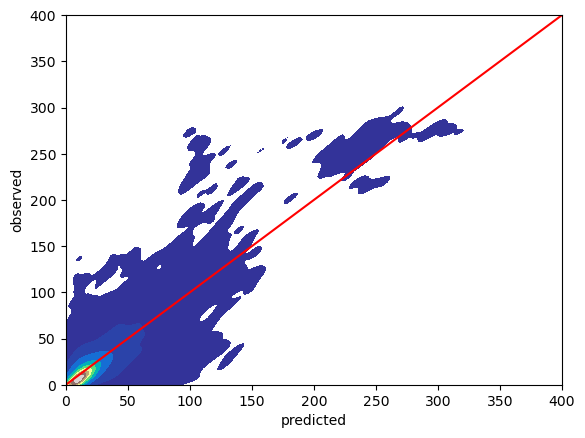

In [63]:
sns.kdeplot(x=qa_pred.flatten(), y=y.flatten(), cmap="terrain", fill=True, bw_adjust=.5,clip=(0,400))
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot([0,400],[0,400],color='r')
plt.show()

In [80]:
bins = np.concatenate([np.arange(0,151,5),np.arange(175,351,25)])
bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 150, 175, 200, 225, 250, 275, 300, 325,
       350])

In [66]:
y.shape

(29102, 1)

In [82]:
for l,u in zip(bins[:-1],bins[1:]):
    idx = np.where((y >= l) & (y < u))
    plt.figure()
    plt.hist([qa_pred[idx], y[idx]],log=True,label=["predicted","observed"],bins=20)
    plt.legend()
    plt.title(f"Predicted and Observed PM2.5 Levels ({l}-{u} µg/m3)")
    plt.xlabel("concentration")
    plt.ylabel("frequency")
    plt.savefig(f"D:/rrfs/joint_histograms/{l}-{u}.png")
    plt.close()

C:\Users\Jeffrey\AppData\Local\Temp\ipykernel_25020\4089673880.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.savefig(f"D:/rrfs/joint_histograms/{l}-{u}.png")


In [105]:
all_qa[['Latitude','Longitude']].loc[all_qa.StateName == "MM"]

,Latitude,Longitude
35199,34.390672,-119.513848
35272,34.390672,-119.513848
35343,34.390672,-119.513848
35415,34.390672,-119.513848
35484,34.390672,-119.513848
...,...,...
52862,40.800691,-124.158468
52940,40.800691,-124.158468
53018,40.800691,-124.158468
53094,40.800691,-124.158468


In [104]:
index = pd.date_range("20200901", "20201003", freq="h", name="date_time_utc")
all_qa['pred'] = reg_qa.predict(all_qa[['pm25_pa','humidity_a']].to_numpy())
for sid, data in all_qa.groupby('AQSID'):
    graph_params = data.groupby("date_time_utc").agg(an_pm=("PM25","first"),
                                                     pred_low=("pred","min"),
                                                     pred_high=("pred","max")).reindex(index)
    plt.figure(figsize=(12,8))
    plt.xticks(rotation=45, ha='right')
    plt.title(f"({sid}) {data.SiteName.iloc[0]} {data.StateName.iloc[0]}, {data.CountryCode.iloc[0]}")
    plt.ylabel("PM2.5 concentration (µg/m3)")
    plt.ylabel("time")
    plt.fill_between(x=graph_params.index,y1=graph_params.pred_low,y2=graph_params.pred_high)
    plt.semilogy(graph_params.index,graph_params.an_pm,color="r",lw=0.75)
    plt.savefig(f"D:/rrfs/station_plots/{sid}.png")
    plt.close()

In [84]:
all_qa.columns

Index(['time_stamp', 'sensor_index', 'humidity_a', 'temperature_a',
       'pressure_a', 'pm2.5_atm_a', 'pm2.5_atm_b', 'pm2.5_cf_1_a',
       'pm2.5_cf_1_b', 'pm10.0_atm_a', 'pm10.0_atm_b', 'pm10.0_cf_1_a',
       'pm10.0_cf_1_b', 'id', 'date_time_utc', 'name', 'location_type',
       'latitude', 'longitude', 'pm25_pa', 'geometry', 'index_right', 'AQSID',
       'SiteName', 'Status', 'EPARegion', 'Latitude', 'Longitude', 'Elevation',
       'GMTOffset', 'CountryCode', 'StateName', 'ValidDate', 'ValidTime',
       'DataSource', 'ReportingArea_PipeDelimited', 'OZONE_AQI', 'PM10_AQI',
       'PM25_AQI', 'NO2_AQI', 'OZONE_Measured', 'PM10_Measured',
       'PM25_Measured', 'NO2_Measured', 'PM25', 'PM25_Unit', 'OZONE',
       'OZONE_Unit', 'NO2', 'NO2_Unit', 'CO', 'CO_Unit', 'SO2', 'SO2_Unit',
       'PM10', 'PM10_Unit'],
      dtype='object')

In [96]:
all_qa.sensor_index.unique().size

92

In [98]:
all_qa.AQSID.unique().size

52

In [65]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent == 'North America']
states = gpd.read_file('C:/Users/Jeffrey/OneDrive - University of Oklahoma/Research/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

C:\Users\Jeffrey\AppData\Local\Temp\ipykernel_26488\329152190.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


2020-08-30 00:00:00
purpleair\test2
purpleair\test3
purpleair\test4
0      29.418444
1       5.019468
2       2.806617
3       1.183941
4       1.541507
         ...    
235     2.398391
236     4.353487
237     8.266754
238     3.715320
239    37.208219
Name: corrected_pm2.5, Length: 240, dtype: float64
0.6795894000000002
2620.3670228


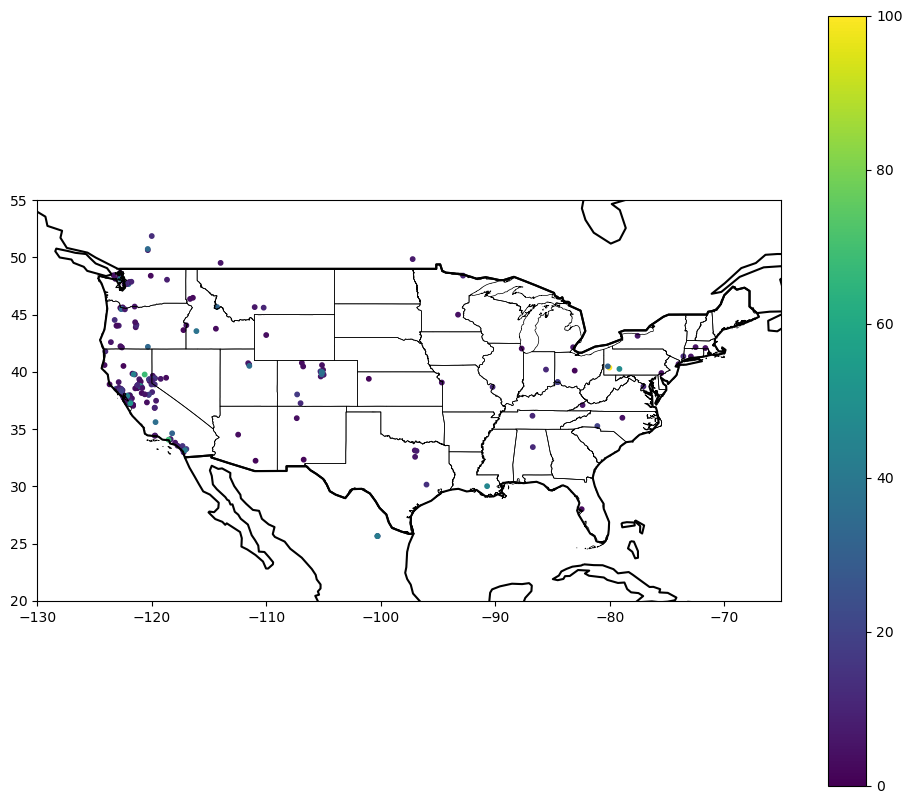

In [102]:
for date in date_range:
    print(date)
    hourly = None
    for dir in glob.glob("purpleair/test*"):
        print(dir)
        try:
            df = pd.read_pickle(f"{dir}/hourly/{date.strftime(format='%Y%m%d_%H')}.pkl")
            if hourly is None:
                hourly = df
            else:
                hourly = pd.concat([hourly,df]).reset_index(keep=False)
        except:
            pass
    if hourly is not None:
        df['corrected_pm2.5'] = (df['pm2.5_cf_1_a'] + df['pm2.5_cf_1_b']) * 0.524 / 2 - (0.0862 * df['humidity_a']) + 5.75
        print(df['corrected_pm2.5'])
        print(df['corrected_pm2.5'].min())
        print(df['corrected_pm2.5'].max())
        df = gpd.GeoDataFrame(data=df, geometry=gpd.points_from_xy(df.longitude,df.latitude))
        
        fig = plt.figure(figsize=(12,10))
        ax = plt.gca()
        ax.set_xlim(-130,-65)
        ax.set_ylim(20,55)
        world.geometry.boundary.plot(edgecolor='k',ax=ax)
        states.geometry.boundary.plot(edgecolor='k',linewidth=0.5,ax=ax)
        df.plot(column='corrected_pm2.5',ax=ax,cmap='viridis',vmax=100,vmin=0,legend=True,markersize=10)
        plt.show()
        break
    break